# Linear relationships in municipality statisitcs: 
## *An automated model of investigating the relationship between municipality statistics and the vote share of political parties.*


<center><h3>Jelle Veldman - 2011313 - u669221 </h3></center>


# Abstract

In this notebook I develop an automated way to search for linear relationships between statistics about municipalities in the Netherlands and the vote shares of Dutch political parties. The first chapter builds a SQLite database and populates it with cleaned data from the CBS and the Election Council. Based on this data, I run scripts that iterate over all the possible combinations of regressions and political parties. From over 2000 linear regressions, 7 met all the criteria for a linear regression model to be valid, of which only five have a meaningful coefficient. Non-linearity and non-normality where the biggest causes for violating the linear model assumptions, together with the incapacity of the independent variable to explain the variation in the dependent variable. From the five regressions that met the criteria, the strongest positive relationship is between the percentage of people that get governmental support before reaching the retirement age and the vote share for the Socialist party. This suggests that there is evidence that the higher the share of people with governmental support before reaching the retirement age in a municipality, the more people vote, on average, on the Socialist Party. Running the same analysis on the data per neighbourhood instead of per municipality might significantly increase the amount of successful regressions as the data will be less divers and more likely to contain a linear relationship. 

# Research Question? 

***Are there solid linear relationships between municipality statistics and the vote shares of political parties?***

# Table of contents

1. Introduction
    1. Importance of the research question
    2. Political parties
2. Obtaining and saving the data
    1. Converting dataframes to SQLite tables
    2. Populating the dataframe 
        1. CBS data
        2. Election data
3. Preparing independent variables 
4. Defining analysis functions
5. Automation of search for linear relationships
   1. Assumptions
   2. Identifying the most accurate regressions
   3. Construct analysis loop
6. Visualising performance of regression
7. Analysing results of regressions
8. Conclusion

## 1. Introduction


### 1.1. Importance of the research question
It will not be long until the billboards will be constructed again, soon to be filled with the faces of local politicians: new elections are close. Wednesday the 16th of March, Dutch citizens will vote for the local municipality elections. Parties and statistical agencies try to predict the elections beforehand using a vast range of methods. Not only are polls and election predictions useful for measuring the popularity of certain parties, it also helps strategic voters to optimize their votes. Next to that, political parties benefit significantly by knowing where their voters are located: Socialist, for example, will not convince many voters to vote for the Socialist Party when targeting the richest municipalities of the country. To find out which municipalities a party should target, this notebook tries to define the linear relationships between the statistics of municipalities and the vote shares on the major Dutch political parties in a structured and automated way. This paper does not aim to suggest a different method of predicting elections, as prediction models are developed to an extent that cannot be matched with a relatively simple python analysis. However, defining which statistics align with higher vote shares of certain parties could be valuable for parties to target their audience or to find voters that could be convinced to change their voting behaviour. If potential voters receive the election commercials closest to their background, it might make voting more optimal and increase the total welfare as parties can target their votes and save on marketing costs. 

This paper will use the basic information from municipalities, obtained from the Dutch [Central Bureau of Statistics (CBS)](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=70072ned&_theme=233) using the CBS api [cbsodata](https://pypi.org/project/cbsodata/). The election data comes from the Dutch [Election Council (Kiesraad)](https://www.verkiezingsuitslagen.nl/) and has been manually downloaded. I decided not to use [Selenium](https://pypi.org/project/selenium/) and [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) to scrape the data from the website as the benefits of automation would nullify against the decrease in reproducability. The data is obtained per municipality. Although an analysis on the level of neighbourhoods would be more accurate considering that it would make the differentiation between e.g. rich and poor areas possible, I chose not to do this as the availability of this data is not as good as on the level of municipalities. Obtaining the election data per neighbourhood requires advanced knowledge of XML files and the key figures per neighbourhood of the CBS are either outdated or protected by a paywall.

Because of the large quantity of data used in this project, I chose to work with a database. The parent table will be a table that contains all the municipality codes that have existed in the Netherlands between 2000 and 2022. Such a table is necessary as there were several reclassifications of municipalities over the past twenty years. Considering the fact that I do not own a server, I decided to use the SQLite dialect for structuring my database. SQLite databases can be stored locally without the need to set up a server. Next to that, SQLite works very well with the pandas package, as the function `pd.DataFrame.to_sql()` and `pd.read_sql()` can easily interact with the database. 

### 1.2. Parties

Underneath, the parties incorporated in this research are displayed with their English translation and description. The description has been obtained from [parlement.com](https://www.parlement.com/id/vh8lnhrpfxut/partijen_in_tweede_en_eerste_kamer) and [nsd.no](https://o.nsd.no/european_election_database/country/netherlands/parties.html). Since the most recent elections in 2021, splitt-offs have caused the number of parties to increase. However, as these parties have participated in clear minority of the elections between 2000 and 2022, they have not been added to this analysis. 

| Party  | English Translation                      | Description                                                                                                                                 |
|--------|------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| VVD    | People's Party for Freedom and Democracy | Conservative, liberal tradition, strong support of private enterprise and the free market. Right-wing oriented.                             |
| PvdA   | Labour Party                             | Social-democratic, supports shared responsibility, stewardship, justice and solidarity. Left-wing oriented.                                 |
| PVV    | Party for Freedom                        | Conservative, economic liberalism with a conservative  view considering culture and immigration.                                            |
| CDA    | Christian Democratic Appeal              | Combines a centre view towards the economy and defence with conservative leanings. Centre oriented.                                         |
| SP     | Socialist Party                          | Evangelises human dignity, equality and solidarity. Focuses on  employment, social welfare, education and health care. Left-wing oriented.  |
| D66    | Democrats 66                             | Exists of radical democrats and progressive liberals. Centre oriented.                                                                      |
| GL     | Green-Left                               | Promotes democracy, environmental respect, social justice and international solidarity. Left-wing oriented.                                 |
| CU     | Christian Union                          | Conservative considering ethics and social issues. Views on  economic and environmental issues centre-left oriented.                        |
| PvdD   | Party for the Animals                    | Focus on animal welfare and animal rights. Promotes personal freedom and responsibility. Left-wing oriented.                                |
| SGP    | Politically Reformed Party               | Conservative, promotes politics according to biblical values and norms. Right-wing oriented.                                                |
| 50plus |                                          | Focuses on the stakes for people older than 50 years.  Not ideological.                                                                     |
| DENK   |                                          | Focuses on respect for all Dutch inhabitants. Main purpose is to  reach tolerance and a society that is social, learning and righteous.     |
| FvD    | Forum for Democracy                      | Strives for more direct democracy and strengthen the national  sovereignty. Right wing oriented.                                            |

## 2. Obtaining and saving the data


### 2.1. Converting DataFrames to SQLite tables
Using SQLite, it is not possible to set foreign keys after the table has been created in the database. Therefore, I need to set these keys manually in a SQLite script. Underneath is the function that creates such a script based on several arguments. *table_name* requires the name you want to give the table in the database. *dataframe* is the table that has to be uploaded to the database. *primary_key* represents the column that should be set as primary of which the input is a string. *foreign_key* represents the column that should be set as a foreign key. Note that the input of this parameter is a list, where the first item is the table, the second item the column it refers to. *foreign_key* requires the names of the primary key and the foreign key to be the same. Both *primary_key* and *foreign_key* have the value 0 as standard. *Connection* represents the connection to the database, which is locally stored and therefore set to a folder.

In [3]:
# Import packages
import os 
import warnings
import pandas as pd
import sqlite3
import json
import statsmodels.api as sm 
import numpy as np
# Set database location
location = str(os.getcwd().replace('\\', '/') +'/Data/PolProj.db')

In [1]:

def write_dbfile(table_name, dataframe, primary_key = 0,  forkey_ref = 0, connection = location):
    # Turn editing warning off 
    pd.options.mode.chained_assignment = None
    # Establish sqlite connection
    con = sqlite3.connect(connection)
    # Open cursor
    cur = con.cursor()
    # Obtain table list and delete table if it already exists
    try:
        cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tableframe = pd.DataFrame(cur.fetchall())
        if tableframe.iloc[:,0].str.contains(table_name).any():
            cur.execute(str('DROP TABLE ' + table_name +';'))
    except IndexError: 
        pass
    # Opening SQLite statement
    cmd_start = str('CREATE TABLE IF NOT EXISTS ' + table_name + ' ( ')
    # Open dataframe with descriptions of dataframe
    descdat = pd.DataFrame(
        {'colnames': dataframe.columns,
        'coltypes':dataframe.dtypes, 
        'special': float("NaN")}
        )
    # Set index back to numeric 
    descdat = descdat.reset_index(drop=True)
    # If primary key matches with colnames, add to descriptive frame
    try:
        to_primary = descdat.loc[descdat['colnames']== primary_key].index[0]
        descdat.special[to_primary] = 'PRIMARY KEY'
    # If not, give message
    except IndexError: 
        #print('No primary key match found')
        pass
    # If foreign key matches with colnames, add to descriptive frame
    if forkey_ref != 0:
        try:
            to_foreign = descdat.loc[descdat['colnames'] == forkey_ref[1]].index[0]
            descdat.special[to_foreign] = 'FOREIGN KEY'
        # if not, give message
        except IndexError: 
            #print('No foreign key match found')
            pass
    # Change description column types to strings
    descdat.coltypes = descdat.coltypes.astype(str)
    # Define replacing string function
    clean_string = lambda x,y: descdat.coltypes.str.replace(x, y)
    descdat.coltypes = clean_string('int64', 'INTEGER')
    descdat.coltypes = clean_string('float64', 'REAL')
    descdat.coltypes = clean_string('object', 'TEXT')
    for i,row in descdat.iterrows():
        # Loop over every row and create SQLite command string. 
        if row[2] == 'PRIMARY KEY': 
            cmd_start += str(str(row[0])+ ' '+ str(row[1]) + 'NOT NULL PRIMARY KEY' + ',')
        else: 
            cmd_start += str(str(row[0])+ ' '+ str(row[1]) + ',')
    # If foreign key mentioned, add foreign key indication to SQLite string
    if forkey_ref != 0: 
        cmd_start += str('FOREIGN KEY(' + forkey_ref[1] + ') REFERENCES ' +
                         forkey_ref[0] + '(' + forkey_ref[1]+ '));')
    else: 
        cmd_start = str(cmd_start[:-1]+');')
    # execute string
    cur.execute(cmd_start)    
    # Close cursor and return string for checking 
    cur.close()
    # Write dataframe to newly created table 
    dataframe.to_sql(table_name, con, if_exists = 'append', index = False)
    return()

### 2.2. Populating the database

Now that the function to create relational tables within a database has been defined, the database can be populated. However, the data necessary for this analysis comes from different sources and therefore has to be downloaded and cleaned. The variable that will link all tables with each other is the municipality code, used as *municode* from now on. The central table will be a list of all municipality codes in the Netherlands that have existed between 2000 and 2022. The other tables will be connected through the central table, as is indicated in the image below: 

![](Figures/project_structure.png)

Before data is put in to the database, it needs to be downloaded and cleaned. The data will be ontained from respectively the Central Bureau of Statistics (CBS) and the Kiesraad (Election Council). In the following chunks, I will obtain CBS data using the CBSodata API, clean it and put it in the database afterwards. For the csv-files from the Election Council, I created a function that loops over the data folders and does the cleaning automatically as the structure of the files is the same. Per iteration, the election data will be added to the database. 

#### 2.2.1 CBS data

In [377]:
# Obtain all minicipalities between 2000 and 2022
muni_all = pd.DataFrame(cbs.get_data('70739ned'))

# Rename columns, set 'municode' as central variable. 
muni_all = muni_all.rename(columns = {'GebiedsOfGemeentecode_3':'municode', 
                                      'EinddatumSorteerveld_7':'enddate'})

# Function for standardising municipality code variable 'municode'
def clean_municode(table):
    remove_string = lambda x: table[~table.RegioS.str.contains(x)]
    # Def strings to remove 
    removables = ['(PV)','(CR)','(LD)','Nederland']
    for item in removables: 
        table = remove_string(item)
    table.dropna(subset = ['municode'], inplace = False)
    clean_string = lambda x: table.municode.str.replace(x, '')
    table.municode = clean_string('GM')
    table.municode = clean_string(' ')
    table.municode = pd.to_numeric(table.municode)
    return(table)

main_data = clean_municode(muni_all)
# Table specific cleaning
clean_string = lambda x: main_data.enddate.str.replace(x, '')
main_data.enddate = clean_string(' ')
main_data.enddate = pd.to_numeric(main_data.enddate)
main_data = main_data[(main_data.enddate >= 20000101) | (main_data.enddate.isnull())]
main_data = main_data.drop_duplicates(subset = ['municode'])

# Write data to database
write_dbfile('general_data',main_data,'municode', 0,location)

In [ ]:
# Import general CBS data
cbs_data = pd.DataFrame(cbs.get_data('70072ned'))
# Rename municipality code to general name 
cbs_data = cbs_data.rename(columns = {'KoppelvariabeleRegioCode_306' : 'municode'})

cbs_data = clean_municode(cbs_data)

# Write data to database
write_dbfile('cbs_data', cbs_data,0,['general_data', 'municode'], location)

C:\Users\jjhve\AppData\Local\Temp/ipykernel_22392/2786362086.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  remove_string = lambda x: table[~table.RegioS.str.contains(x)]


No primary key match found


()

#### 2.2.2. Election data

Underneath is the function to get all the election data from the `Elections` folder in the database. The script opens the data directory, scans which folders are in there and opens them one by one. When having opened a folder, is scans which files are in this folder and opens them one by one. Then the files are cleaned and put in the database. Since the files are all similar, the cleaning process is the same for each of the files. 

Since 2000, a vast variety of parties have participated in local, provincial and national elections. Whereas many of them have frequently registered in elections, a limited amount of them succeeded to get seats in parliament. Especially in the municipality elections a large amount of local parties participated that are represented in only one or two municipalities. To keep the focus of this analysis clear, I decided to only include the parties that were represented and won seats in the parliamentary election of both 2017 and 2021. Young parties such as DENK and FvD will have less data than the parties that have been present in Parliament since 2000, but as they have been part of the Dutch political landscape for almost five years it is essential to include them. Setting these boundaries filters out a vast amount of local, poorly supported parties. As the list of parties to exclude is long, I filtered by using a list of parties to include, located in the file `colnames.csv`. This table is used for both filtering data as for giving the columns of party vote results a standardised name that can be easily called when requesting regressions. 

In [290]:
# define data map 
def clean_elec():
    # Define directory 
    directory = str(os.getcwd())
    # Import column names + replacements
    colnamers = pd.read_csv(str(directory + '\\Data\\colnames.csv'))
    # Create list to filter out small parties (local parties in municipality elections, etc)
    filter_list = list(colnamers.iloc[:,0])
    # Locate data directory 
    directory += str('\\Data\\Elections')
    for file in os.listdir(directory): 
        # Loop through folders
        directory_temp = str(directory + '\\' + str(file))
        for item in os.listdir(directory_temp):
            # Iterate over csv's in folder
            data = pd.read_csv(str(directory_temp + '\\' + item), sep = ';').rename(columns = {'RegioCode' : 'municode'})
            # Filter out small parties
            data = data[data.columns.intersection(filter_list)]
            # Convert new and old column names to dictionary
            filter_dict = dict(zip(colnamers.colname_old, colnamers.colname_new))
            # Rename columns
            data.rename(columns = filter_dict, inplace = True)
            # Define cleaning function
            remove_signs = lambda x:  data.columns.str.replace(x, '')
            # Define strings to remove
            removables = ['.', '(', ')', '!', '&', '-', ":", '/', '+']  
            # iterate over string list and remove them 
            for character in removables:
                    data.columns = remove_signs(character) 
            # Define string cleaning function
            clean_string = lambda x: data.municode.str.replace(x, '')
            # Filter out everything else except municipalities
            data = data[data['municode'].str.contains('G')]
            data.municode = clean_string('G')
            data.municode = clean_string(' ')
            # Convert municode to numeric
            data.municode = pd.to_numeric(data.municode)
            filename = item.replace('.csv', '')
            # Clean and store data in database
            write_dbfile(filename,data, 0, ['general_data', 'municode'],location)
    return()
clean_elec()


## 3. Preparing the independent variables

With many different variables available in the database, a structured way of analysing is essential to prevent overlooking potential linear relationships of variables and parties. In the code chunk underneath I created a list of all the variables available in the dataframe. Some are in a list, which means that they are already relative and are therefore not influenced by the population of a certain municipality. The variables that are in a dictionary are absolute and still have to be divided by a certain variable. This variable is noted as the key of the dictionary and is often `TotaleBevolking_1`, or total population. The value of this key then is a list of all the variables that have to be divided by the key of the dictionary. The lists and dictionaries are divided per topic, which causes some keys of dictionaries to be similar. In the end, all the lists and dictionaries are merged into a list and saved as a .json file, which will be used in further analysis. To get an overview of the meaning of all the variables, run `cbs_meta = pd.DataFrame(cbs.get_meta('70072ned'))`. I did not include this table considering it would diminish the readability of this document. 

In [127]:
import json
# script for defining relive units

# Relative age groups
rela_age = ['JongerDan5Jaar_13', 'k_5Tot10Jaar_14' , 'k_10Tot15Jaar_15', 'k_15Tot20Jaar_16','k_20Tot25Jaar_17',  'k_25Tot45Jaar_18', 
            'k_45Tot65Jaar_19', 'k_65Tot80Jaar_20','k_80JaarOfOuder_21']
# Relative Green and Gray press, Green press being the 'youth' from 0 - 20 and the grey press as 65 years and older. 
rela_press = ['GroeneDruk_23', 'GrijzeDruk_24']
# Relative marital status
rela_huw = ['Ongehuwd_30', 'Gehuwd_31', 'Gescheiden_32', 'Verweduwd_33']
# Percentage of immigrants from different backgrounds
rela_immi = ['NederlandseAchtergrond_43', 'TotaalMetMigratieachtergrond_44', 'WesterseMigratieachtergrond_45', 
             'TotaalNietWesterseMigratieachtergrond_46', 'Marokko_47','VoormaligeNederlandseAntillenAruba_48', 
             'Suriname_49', 'Turkije_50', 'OverigNietWesterseMigratieachtergrond_51']
# Urbanisation rate, still needing to be divided by the total population
rela_urban = {'TotaleBevolking_1':['ZeerSterkStedelijk_52', 'SterkStedelijk_53', 'MatigStedelijk_54', 
                                   'WeinigStedelijk_55', 'NietStedelijk_56']}
# Population density, not necessary to divide as it's already standardised
rela_density = ['Bevolkingsdichtheid_57']
# Relative birth- and mortality rates
rela_birthmort = ['GeboorteRelatief_59', 'SterfteRelatief_61', 'GeboorteoverschotRelatief_63']
# Diseases and mortality, still has to be divided by total population
rela_desease = {'TotaleBevolking_1':['Nieuwvormingen_64','ZiektenVanHartEnVaatstelsel_65','ZiektenVanAdemhalingsstelsel_66',
                                     'UitwendigeDoodsoorzaken_67', 'OverigeDoodsoorzaken_68']}
# Relative migration rates
rela_migration = ['BinnenlandsMigratiesaldoRelatief_72', 'VerhuismobiliteitRelatief_73','MigratiesaldoRelatief_77', 
                  'BevolkingsgroeiRelatief_80']
# Relative household sizes
rela_househ = ['Eenpersoonshuishoudens_86', 'HuishoudensZonderKinderen_87','HuishoudensMetKinderen_88', 
               'GemiddeldeHuishoudensgrootte_89']
# Relative housing statistics
rela_houses = ['SaldoVermeerderingWoningenRelatief_92','Woningdichtheid_93', 'Koopwoningen_94',
               'Huurwoningen_95', 'EigendomOnbekend_96']
# Primary education, has to be divided by total population
rela_primary = {'TotaleBevolking_1':['SpeciaalBasisonderwijs_101','SpecialeScholen_102']}
# Seconday education, has to be divided by total population
rela_highs = {'TotaleBevolking_1':['VoortgezetOnderwijs_103']}
# Tertiary education,  has to be divided by total population
rela_study = {'TotaleBevolking_1':['BeroepsopleidendeLeerweg_104', 'BeroepsbegeleidendeLeerweg_105', 'HogerBeroepsonderwijs_106', 
                                   'WetenschappelijkOnderwijs_107']}
# Education degrees, has to be divided by total population
rela_finstudy = {'TotaleBevolking_1':['VoortgezetOnderwijs_108', 'MiddelbaarBeroepsonderwijs_109','HogerBeroepsonderwijsBachelor_110',
                                      'WoMasterDoctoraal_111']}
# Percentage of professions
rela_job = ['ALandbouwBosbouwEnVisserij_117', 'BFNijverheidEnEnergie_118', 'GNCommercieleDienstverlening_119','OUNietCommercieleDienstverlening_120']
# spendable income, since it's average of a specific type of household, averaging is not necessary
spend_inc = ['ParticuliereHuishoudensExclStudenten_132','TypeEenpersoonshuishouden_133', 'TypeEenoudergezin_134', 'TypePaarZonderKind_135', 
             'TypePaarMetKindEren_136', 'BronInkomenAlsWerknemer_137', 'BronInkomenAlsZelfstandige_138', 
             'BronOverdrachtsinkomen_139', 'WoningbezitEigenWoning_140', 'WoningbezitHuurwoning_141']
spend_incmed = ['ParticuliereHuishoudensExclStudenten_142','TypeEenpersoonshuishouden_143', 'TypeEenoudergezin_144', 'TypePaarZonderKind_145', 
             'TypePaarMetKindEren_146', 'BronInkomenAlsWerknemer_147', 'BronInkomenAlsZelfstandige_148', 
             'BronOverdrachtsinkomen_149', 'WoningbezitEigenWoning_150', 'WoningbezitHuurwoning_151']
# Welfare payments,  has to be divided by total population
rela_welfare = {'TotaleBevolking_1':['UitkeringsontvangersTotaal_152', 'TotDeAOWLeeftijd_153', 'VanafDeAOWLeeftijd_154', 'Werkloosheid_155',
                'BijstandGerelateerdTotAOWLeeftijd_156', 'BijstandGerelateerdVanafAOWLeeftijd_157', 'BijstandTotDeAOWLeeftijd_158', 
                'ArbeidsongeschiktheidTotaal_159','WAOUitkering_160', 'WIAUitkeringWGARegeling_161', 'WajongUitkering_162', 
                'AOW_163']}
# Companies in municipality, has to be divided by the total amount of businesses in a municipality
rela_business= {'BedrijfsvestigingenTotaal_164':['ALandbouwBosbouwEnVisserij_165', 'BFNijverheidEnEnergie_166', 
                                                 'GIHandelEnHoreca_167', 'HJVervoerInformatieEnCommunicatie_168', 
                                                 'KLFinancieleDienstenOnroerendGoed_169', 'MNZakelijkeDienstverlening_170',
                                                 'RUCultuurRecreatieOverigeDiensten_171']}
# Surface usage, has to be divided by total population
rela_farm = {'TotaleOppervlakte_183':['Akkerbouw_184', 'TuinbouwOpenGrond_185', 'TuinbouwOnderGlas_186',
                                      'BlijvendGrasland_187', 'NatuurlijkGrasland_188', 'TijdelijkGrasland_189', 'Groenvoedergewassen_190']}
# Transport, already per 1000 inhabitants
rela_transport = ['PersonenautoSRelatief_197', 'PersonenautoSParticulierenRelatief_199', 'MotorfietsenRelatief_202', 'VoertuigenMetBromfietskenteken_204']
# Living stats, distance is in kilometers and quantity is within 3 or 20 km
rela_distance = ['AfstandTotHuisartsenpraktijk_209','AantalHuisartsenpraktijkenBinnen3Km_210', 'AfstandTotHuisartsenpost_211', 
                 'AfstandTotZiekenhuis_212', 'AantalZiekenhuizenBinnen20Km_213', 'AfstandTotKinderdagverblijf_214', 'AantalKinderdagverblijvenBinnen3Km_215', 
                 'AfstandTotSchoolBasisonderwijs_216', 'AantalBasisonderwijsscholenBinnen3Km_217', 'AfstandTotSchoolVmbo_218', 
                 'AantalScholenVmboBinnen5Km_219', 'AfstandTotSchoolHavoVwo_220', 'AantalScholenHavoVwoBinnen5Km_221', 'AfstandTotGroteSupermarkt_222', 
                 'AantalGroteSupermarktenBinnen3Km_223', 'AfstandTotRestaurant_224', 'AantalRestaurantsBinnen3Km_225', 'AfstandTotBibliotheek_226', 
                 'AfstandTotBioscoop_227', 'AantalBioscopenBinnen10Km_228', 'AfstandTotZwembad_229','AfstandTotSportterrein_230', 
                 'AfstandTotOpenbaarGroen_231', 'AfstandTotOpritHoofdverkeersweg_232',  'AfstandTotTreinstation_233']
# litter, still to divide by TotaalHuishoudelijkAfval_234
rela_litter = {'TotaalHuishoudelijkAfval_234':['HuishoudelijkRestafval_235', 'GrofHuishoudelijkRestafval_236', 'GftAfval_237', 'OudPapierEnKarton_238', 
               'Verpakkingsglas_239', 'Textiel_240', 'KleinChemischAfval_241', 'OverigHuishoudelijkAfval_242' ]}
# land usage, already relative
rela_land = ['Verkeersterrein_255', 'BebouwdTerrein_256', 'SemiBebouwdTerrein_257','Recreatieterrein_258', 'AgrarischTerrein_259', 
             'BosEnOpenNatuurlijkTerrein_260']
# land ha per 1000 inhabitants
rela_landpi = ['Verkeersterrein_261','BebouwdTerrein_262', 'SemiBebouwdTerrein_263', 'Recreatieterrein_264','AgrarischTerrein_265', 
               'BosEnOpenNatuurlijkTerrein_266']

completelist = [rela_age, rela_birthmort, rela_business, rela_density, rela_desease, rela_distance, rela_farm, 
                rela_finstudy, rela_highs, rela_househ, rela_houses, rela_huw, rela_immi, rela_job, rela_land, 
                rela_landpi, rela_litter, rela_migration, rela_press, rela_primary, rela_study, 
                rela_transport, rela_urban, rela_welfare, spend_inc, spend_incmed]

def save_json(location, file): 
    string = json.dumps(file)
    jsonFile = open(location, "w")
    jsonFile.write(string)
    jsonFile.close()

save_json('Data/itertable.json',completelist)

## 4. Defining analysis functions

Since the data of elections and the CBS statistics are divided over several tables, several functions are necessary to get all the data in the same dataframe so that it can be used in regressions and other analysis. The first function, `elec_clean`, cleans the names of the tables of everything except the year the elections were held in. 

In [22]:
def elec_clean(string): 
    replacables = ['GR', 'PS', 'TK', 'EP', '_gem', ' ']
    for repl in replacables: 
        string = string.replace(repl, '')
    return(string)

The second function,`standardiser`, only takes one argument, the x variable of a potential regression. With x_var defined, the function opens the itertable created before and checks whether the variablename is within a list or dicionary. If it's in a dictionary, it obtains the key value of that dictionary and returns the name of the column by which the statistic has to be divided. If the statistic is in a list, then it returns a False value, which is used in the third function request_elecstat. 

In [20]:
def standardiser(x_var):
    FileObject = open('Data/itertable.json')
    readfile = FileObject.read()
    # Open json file with lists and dictionaries
    itertable = json.loads(readfile)
    # Create list for standardised values
    standardised = []
    todo = []
    for item in itertable: 
        # if item in list, append standardised kist
        if type(item) == list: 
            standardised.append(item)
        else: 
        # if not, then add to dictionary list 'todo'
            todo.append(item)
    # unpack standardised list
    standardised = [key for sublist in standardised for key in sublist]
    # If x_var is in the standardised list, set divider to False
    if x_var in standardised: 
        divider = False
        return(divider)
    # if not, set the divider as the key of the dictionary it's found in
    else: 
        for item in todo: 
            if any(any(x_var in s for s in subList) for subList in item.values()): 
                divider = list(item.keys())[0]
            else: 
                next
        try:
            return(divider)
        # If the x_var cannot be found, raiser error
        except UnboundLocalError as err: 
            print(str('Error: ' + x_var + ' not found in variables.'))
            raise(err)

The third, longer function `request_elecstat` uses the elec_clean function to match data with the same years. The variables of input are as follows:

`statistic`: One of the statistics listed in the metadata of the CBS table. <br>
`party`: The party with which the cbs data has to be compared in terms of votes. <br>
`divider`: False if the statistics is already relative, if not then it has to be the name of the column by which the statistic has to be divided. <br>
`con`: The location of the SQLite database. 

The result of this function is a dataframe obtained by sending a SQLite query to the database. The dataframe holds information of the different periods, statistics, the municipality codes and the amount of votes on the specified party. In case `divider` was specified, the column by which the statistic has to be divided has been included in the table as well. For security, a message is printed if a party was not found for certain elections. 

In [19]:
def request_elecstat(statistic, party, divider, con = location):
    # Establish connection
    con = sqlite3.connect(con)
    # get list of all tables 
    table_frame = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)
    # Filter out the election data (no CBS and general data)
    elections = table_frame[table_frame.name.str.contains('_gem')]
    # Create skeleton of dataframe
    output = pd.DataFrame()
    for i, row in enumerate(elections.iterrows()):
        # Select table name and clean year
        elec_tablename = row[1][0]
        year = elec_clean(elec_tablename)
        cur = con.cursor()
        # Open SQL query
        query = str(
        'SELECT cbs_data.Perioden,'+
        'cbs_data.' + statistic +
        ', cbs_data.municode'
            )
        # If there is a divider, include this in query
        if divider != False: 
            query += str(
                ', cbs_data.' + 
                divider)
        query += str(
            ', t1.'+party + 
            ', t1.GeldigeStemmen FROM cbs_data INNER JOIN '+
            elec_tablename + 
            ' AS t1 ON t1.municode = cbs_data.municode WHERE Perioden = '+
            year + ' GROUP BY cbs_data.municode;')
        # Try to execute the query
        try: 
            data = cur.execute(query)
            data = pd.read_sql(query,con)
            output = output.append(data)
            # If the query does not succeed, then the party was not in the columns and therefore print warning message. 
        except sqlite3.DatabaseError: 
            print(str('WARNING: ' + party + ' did not participate in the '+ elec_tablename + ' elections.'))
            pass
    return(output)

With the data collected and formatted, the functions for the analysis can be defined. Underneath is the function that gets the requested data based on the given variables `statistic` and `party`. The result is a dataframe where the statistic, if necessary, has been divided by the total population of that statistic. Also, the NA-values have been filtered out. It uses the previous two functions `standardiser` and `request_elecstat`.

In [18]:
def get_regresdat(statistic, party):
    # Define the divider for the statistic
    divider = standardiser(statistic)
    # Obtain the data
    data = request_elecstat(statistic, party, divider)
    # Convert to numeric
    data = data.apply(pd.to_numeric)
    # Divide amount of votes for a party by the total amount of valid votes
    data['perc_party'] = data[party]/data['GeldigeStemmen']
    # Return original data if divider is absent
    if divider == False: 
        return(data.dropna())
    # Create relative statistic by defined divider variable
    if type(divider) == str: 
        data[statistic] = data[statistic]/data[divider]
        return(data.dropna())

## 5. Automation of the search for linear relationships


### 5.1: Assumptions

Because of the large amount of variables used in this analysis, running regressions one by one would be messy and severely time-consuming. Therefore, I created several scripts that run these regressions automatically and save the most important statistics. However, preparatory to running regressions, the data has to meet certain asusumptions. These assumptions, obtained from the book *Statistical Methods for Business and Economics (Gert Nieuwenhuis)* are as follows: 

1. **Linearity:** To check whether the percentage of votes for a certain party depends linearly on a specific statistic, an auxiliary model is used. The standard shape of a linear regression is $Y_i = \beta_0 + \beta_1x_{i1} + \varepsilon$. To find whether a second order model might improve things, the predictions of the previously mentioned model are taken, squared and saved as variable $y^2_i$. Next, this variable is added to the regression, resulting in $Y_i = \beta_0 + \beta_1x_{i1} + \gamma \hat{y}^2_i + v_i$ where $v_i$ is the new error term. To check whether the squared values would improve the model, the p-value of the coefficient of the variable $\hat{y}^2_i$ has been taken out and tested against a certain alpha-value (standard is 0.05). If this coefficient is significant, it means that the inclusion of the second order terms would improve the model. In the functions created in this essay, no point would be added to the regression value. 
2. **Independence of error terms:** To check for autocorrelation, a Durbin-Watson test could be performed on the residuals of the data. The Durbin-Watson test tests whether data from an earlier period inlfuences the data from a later period. The values resulting from a Durbin-Watson test are between 0 and 4 where values closer to zero indicate positive autocorrelation and values closer to 4 indicate negative autocorrelation. Although the observations of this analysis have been measured over several years, there are less than 22 observations in terms of dates against over 350 observations in terms of municipalities. Therefore, autocorrelation is not considered as a major violation in this search for linear relationships. 
3. **Normality:** The degree of normalility of the residuals will be indicated by using a Lilliefors test. Although literature argues that the Lilliefors test might not be the strongest model to test for normality, it has been extensively described in the book *Statistical Methods for Business and Economics (Gert Nieuwenhuis)* and therefore I assume that this is an appropriate way for testing on normality. The Lilliefors test tests with *H0: residuals are normally divided* against *H1: residuals are not normally divided*. Therefore, if the p-value of the Lilliefors test is lower than the significance level, H0 can be rejected. This means that the grade of the model will increase if the Lilliefors p-value is larger than the significance level. 
4. **Homoskedasticity:** For data to be homoskedastic, the variance of the residuals has to be more or less the same across the different values of the chosen statistic. This is tested by taking the residuals of the regression of a statistic on the percentage of votes for a specific party.  These residuals are then squared and used as the dependent observations in a new model. The independent variable is still the statistic indicated in the function. This model is then tested with *H0: No heteroskedasticity has been detected in the model* vs *H1: heteroskedasticity has been detected in the model*. The grade of the model will therefore only increase if the p-value of the coefficient of the statistic on the squared residuals is not significant. 

Next to three of the four assumptions, the grade of the model is determined by two other factors. Firstly, the $r^2$ is calculated to find out what percentage of the variance in the percentage of votes can be explained by the chosen statistic. For the grade of the model to increase, the $r^2$ has the be higher than 0.05. Although this might seem to be a very low value for the $r^2$ statistic, the assumption has been made that there are many factors that cause variation in the percentage of votes for a certain party. Therefore, a minimal value of $r^2 = 0.05$ seems suitable. Next to that, the significance of the coefficient of the statistic is measured. The grade of the model increases if the coefficient is significant because this proves that the statistic has influence on the vote share of a certain party. 

### 5.2: the most accurate regressions
Altogether this means that the best score the model can get is a 5. In that case, the most important assumptions for a linear regression have been met, does the statistic explain a reasonable percentage of the variation in the dependent variable and is the coefficient of the statistic significant. According to Nieuwenhuis (2009), the violations of the assumptions of a linear model might be reduced by either taking the natural logarithm or square root from the dependent variable, divide one by the dependent variable or square the dependent variable. In the function below, the data is obtained by using the function `get_regresdat`, reshaped and expanded with the suggested transformations of the dependent variable. 

In [17]:
def set_checkerdata(statistic, party):
    # Get data
    data = get_regresdat(statistic, party)
    # Reshape data to make it suitable for regression
    data[statistic] = data[statistic].values.reshape(-1,1)
    data['perc_party'] = data['perc_party'].values.reshape(-1,1)
    # Column with natiural logarithm of dependent variable
    data['perc_partLOG'] = np.log(data['perc_party'])
    # Column with one divided by the dependent variable
    data['perc_partDIV'] =  1/data['perc_party']
    # Column with dependent variable to the power two
    data['perc_partPW2'] = np.power(data['perc_party'],2)
    # Column with the square root of dependent variable
    data['perc_partSRT'] = np.sqrt(data['perc_party'])
    # Add constant for regression analysis
    data['const'] = 1
    return(data)

To valuate or grade the model, the function `val_calc` has been created. It takes the values that test whether the assumptions of a linear model hold as arguments and calculates how many of these assumptions hold for a certain linear regression. The score of the regression is the output of the function. 

In [302]:
def val_calc(model, lilfor, linear_val, homosked_val, alpha): 
    val = 0
    # Check for r_squared
    if model.rsquared > 0.05: 
        val += 1
    # Check for significance variable
    if model.pvalues[1] < alpha: 
        val += 1
    # Check for Lilliefors
    if lilfor[1] > alpha:
        val += 1
    # Check for linearity
    if linear_val[1] > alpha: 
        val += 1
    # Check for homoskedasticity
    if homosked_val[1] > alpha: 
        val += 1
    return(val)

The columns of alternative dependent variables were created in `set_checkerdata` to see if the data could be transformed in such a manner that reduces the amount of model assumptions that are violated. The function `assumption_scores` tests the assumptions of all the variants and adds them to an empty dataframe. Then, based on the score, the best variant is taken out and returned. Note that the significance level has been set to 0.05. This value can be changed manually when filling in the third argument when calling the function. 

In [299]:
def assumption_scores(statistic, party, alpha = 0.05): 
    # Turn off warnings 
    warnings.filterwarnings('ignore')
    # Get transformed columns 
    data = set_checkerdata(statistic, party)
    # If dataframe appears to be empty, return "0" values. 
    if len(data) < 5: 
        result = pd.DataFrame([party, statistic, 'Empty', 0,0,0,0,0,0,0],
            columns = ['Party', 'Statistic','Type', 'Coeff', 'pval_coeff', 'r2', 'Lilliefors', 'Linearity', 'Heteroscedasticity', 'Model_score'])
        return(result)
    # Define dict with different types of transformed columns as keys and columns as item. 
    votes_types = {'votes': data['perc_party'], 'votes_div':data['perc_partDIV'], 'votes_log':data['perc_partLOG'],
                   'votes_square':data['perc_partPW2'],'votes_sqrt': data['perc_partSRT']}
    # Create empty dictionary for scores
    scores = {}
    # Create empty dataframe for the scores of the transformed columns
    result = pd.DataFrame(columns = ['Party', 'Statistic','Type', 'Coeff', 'pval_coeff', 'r2', 'Lilliefors', 'Linearity', 'Heteroscedasticity', 'Model_score'])
    for key, value in votes_types.items():
        # Run linear regression
        model = sm.OLS(value, data[['const',statistic]]).fit()
        # Save predicted values and residuals incl. squared versions. 
        data['pred'] = model.predict()
        data['pred2'] = np.power(data['pred'],2)
        data['resids'] = model.resid
        data['resids2'] = np.power(data['resids'],2)
        # Replace infinite by nan
        data = data.replace([np.inf, -np.inf], np.nan)
        if data.isna().all()[-4:].all():
            # If all the values are nan note 0 for scores
            scores[key] = 0
            result.loc[len(result)] = [party, statistic, key, 0,0,0,0,0,0,0]
            next
        else:
            # If not, obtain earlier stated statistics defining the performance on that assumption
            lilfor =  sm.stats.diagnostic.lilliefors(data['resids'], dist = 'norm', pvalmethod = 'approx')
            linearity = sm.OLS(value,data[['const', statistic, 'pred2']]).fit()
            linear_val = [linearity.params[1], linearity.pvalues[2]]
            hetero = sm.OLS(data['resids2'], data[['const',statistic]]).fit()
            hetero_val = [hetero.params[1], hetero.pvalues[1]]
            # Use val_calc function to define the score based on p-values 
            val = val_calc(model, lilfor, linear_val, hetero_val, alpha)
            # Give score to this variation of the dependent variable
            scores[key] = val
            # Put the values that gave the score in dataframe. 
            result.loc[len(result)] = [party, statistic, key, model.params[1], model.pvalues[1], model.rsquared,  lilfor[1], linear_val[1], hetero_val[1], val]
    # Find best score
    max_name = max(scores, key = scores.get)
    # Take out the best performing values and return them
    max_val = result[result['Type'] == max_name]
    return(max_val)


### 5.3. Construct analysis iteration

Calling the function above will return the best regression that can be made with the statistic and party given as input. Since our variety of parties and statistical variables sums up to over a 2000 possible combinations, a structured way of analysing is necessary in order not to overlook relationships between statistics and the percentage of votes for a certain party. To obtain a list of all the statistics possible, the function `get_alloptions` has been created. It opens the earlier specified .json file with the lists and dictionaries of possible variables and unlists everything into one large list. The output of the function is this flattened list of lists and dictionaries. 

In [300]:
import itertools
import time
from tqdm import tqdm
def get_alloptions(): 
    from itertools import chain
    # Find file
    FileObject = open('C:/users/jjhve/Documents/TilburgUniversity/PolProj/itertable.json')
    readfile = FileObject.read()
    itertable = json.loads(readfile)
    temp = []
    for item in itertable: 
        if type(item) == dict: 
            step = list(chain(*list(item.items())))
            temp.append(step[1])
        else: 
            temp.append(item)
    temp = list(chain(*temp))
    return(temp)

`get_alloptions()` will be used in the next function, `regress_all`. This function firstly removes the old results file and then loads all possible statistics and parties. The statistics and parties are then merged in a list with all the possible combinations of statistics and parties. The function loops through this list and gets all statistical values and scores of the best-scoring regression per combination. In case a value has too few rows, an error is raised, and the row will be filled with zeroes. 

**WARNING FOR WHEN GRADING**: 

*The code below is very slow and takes about an hour to complete. If you want to check the outcome of the script underneath quickly, then please consult `final_values.csv`*. 

In [303]:
def regress_all(alpha = 0.05):
    try: 
        os.remove('statvals.csv')
    except FileNotFoundError: 
        pass
    import itertools
    q = get_alloptions()
    # Get a list of all the parties using the colnames file
    parties = list(pd.read_csv('Data/colnames.csv').iloc[10:,1])
    # remove duplicates
    parties = list(dict.fromkeys(parties))
    # Get all combos
    combos = list(itertools.product(q, parties))
    values = pd.DataFrame(columns = ['Party', 'Statistic','Type', 'Coeff', 'pval_coeff', 'r2', 'Lilliefors', 'Linearity', 'Heteroscedasticity', 'Model_score'])
    for item in tqdm(combos):
        try:
            get_values = assumption_scores(item[0], item[1], alpha)
        except ValueError: 
            get_values = pd.Series([item[1], item[0],0,0,0,0,0,0,0,0],
                               index = ['Party', 'Statistic','Type', 'Coeff', 'pval_coeff', 'r2', 'Lilliefors', 'Linearity', 'Heteroscedasticity', 'Model_score'])
        values = values.append(get_values, ignore_index = True)
        values.iloc[:,3:8] = values.iloc[:,3:8].round(4)
        values.to_csv('statvals.csv', index = False)
    return(values)
regress_all()

100%|██████████| 2093/2093 [59:59<00:00,  1.72s/it] 


,Party,Statistic,Type,Coeff,pval_coeff,r2,Lilliefors,Linearity,Heteroscedasticity,Model_score
0,VVD,JongerDan5Jaar_13,votes_square,-0.0032,0.0,0.0125,0.0,0.2572,1.568419e-13,2
1,D66,JongerDan5Jaar_13,votes_sqrt,-0.0364,0.0,0.1792,0.0,0.9642,3.489568e-08,3
2,PVV,JongerDan5Jaar_13,votes_div,0.8227,0.0,0.0077,0.0,0.0818,2.184352e-01,3
3,CDA,JongerDan5Jaar_13,votes_log,0.1696,0.0,0.1097,0.0,0.0001,1.493743e-01,3
4,SP,JongerDan5Jaar_13,votes,-0.0118,0.0,0.0615,0.0,0.0000,6.173711e-11,2
...,...,...,...,...,...,...,...,...,...,...
2088,PvdD,WoningbezitHuurwoning_151,votes_log,-0.0703,0.0,0.1678,0.0,0.1792,9.893843e-01,4
2089,CU,WoningbezitHuurwoning_151,votes_square,0.0005,0.0,0.0125,0.0,0.3651,9.676255e-02,3
2090,SGP,WoningbezitHuurwoning_151,votes_square,0.0019,0.0,0.0540,0.0,0.9262,2.383911e-01,4
2091,DENK,WoningbezitHuurwoning_151,votes,-0.0025,0.0,0.2412,0.0,0.0000,6.863600e-16,2


The script that creates all the statistical values of the regressions automatically saves the resulting dataframe in `statvals.csv`. Because of a large amount of data and the usage of understandable rather than quick code, the script `regress_all` is relatively slow as it takes an hour and 23 minutes to complete. To save the reader time, the results of `regress_all` with a significance level of 0.05 have been saved in the file `final_values.csv`. This file will also be used for investigating the results of the regressions. 


## 6. Visualising the performance of the regressions
The functions `val_calc` and `assumption_scores` checked whether changing the dependent variable by a certain degree would improve the score of the model. The histogram below shows the frequency of which the modifications of the dependent variable have been used as it counts how often e.g. *votes_square* appears in the column ['Type'] dataframe.

[Text(0.5, 1.0, 'Types of dependent variables')]

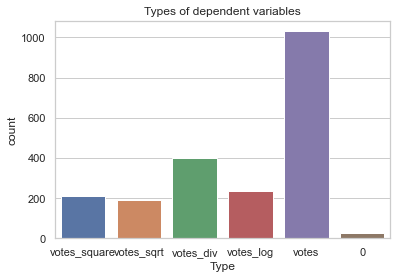

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


df = pd.read_csv('statvals.csv')
sns.countplot(x = 'Type', data = df).set(title = 'Types of dependent variables')

The plot shows that the biggest proportion of the models were the best in the way that they came from the database. However, many dependent variables have been changed in order to improve the score. From all the changes possible, dividing one by the dependent variable seemed to work best. 

To find out to what extent linear regressions can be used to research the relationship between vote shares and the statistics available in the database, the model scores are needed. As stated before and based on the function `val_calc`, 5 would be the perfect score of a regression. The results are displayed in the histogram underneath, that shows the frequency of the regression scores. 

[Text(0.5, 1.0, 'Score of Regressions')]

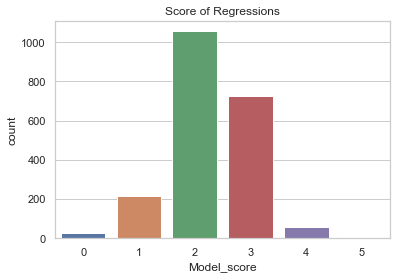

In [5]:
sns.countplot(x = 'Model_score', data = df).set(title = 'Score of Regressions')

The figure above shows that a clear majority of the regressions got a score of either 2 or 3, which is not at all sufficient for drawing conclusions. Next to that there is not a single regression that meets all six requirements. The group of regressions that violates only one of the assumptions consists of the best performing model. These regressions will be discussed in more detail further on. As the majority of the regressions underperforms, a further investigation is needed to find out which requirements are often met and which ones are not. 

To visualise this, the function `requirement plot` has been created. It needs the `final_values.csv` dataframe (see above) as input. The *value* argument has to be one of the column names that indicate the significance of the $r^2$, coefficient, p-values or one of the assumptions for a linear regression. The output is a bar chart based on the amount of observations that were sufficient and insufficient together with a *kernel density estimation*. The latter has been used to give a better picture of the spread. 

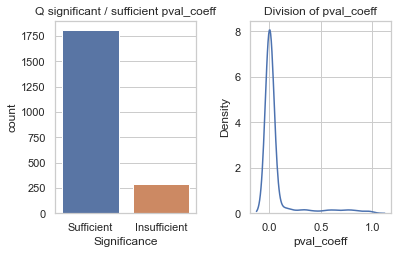

In [339]:
def requirement_plot(data, value,alpha = 0.05,):
    # Define when a value is sufficient and when not
    if value == 'pval_coeff':
        data['Significance'] = np.where(data[value] < 0.05, 'Sufficient', 'Insufficient')
    elif value in ['r2', 'Lilliefors', 'Linearity',	'Heteroscedasticity']:
        data['Significance'] = np.where(data[value] > 0.05, 'Sufficient', 'Insufficient')
    if value == 'Coeff': 
        plot = sns.boxplot(x = data[value], showfliers = False).set(title = str('Division of '+value))
        plt.show()
        plt.close()
        return
    # Create plot environment
    fig, ax = plt.subplots(1,2)
    sns.countplot(x = data['Significance'], data = data, ax = ax[0], order = ['Sufficient', 'Insufficient']).set(title = str('Q significant / sufficient ' + value))
    sns.kdeplot(x = data[value], ax = ax[1]).set(title = str('Division of '+value))
    fig.tight_layout(pad = 2.0)
    plt.show()
    plt.close()	
requirement_plot(df, 'pval_coeff')

The plot of the coefficient's p-value shows that the majority of the regressions has a significant coefficient (marked with *sufficient*). The density estimation also shows that the values of pval_coeff are centered around 0. According to the density plot, it seems as if there are negative p-values in the data. Running `min(df['pval_coeff'])` shows that this is not the case and that this line on the left of zero is a mere effect of the smoothening. 

The large number of significant coefficients indicates there are many relationships between statistics and share of votes for certain parties. However, these relationships could be negligible. As the coefficient itself cannot be tested against any significance level, there is a separate procedure for the value *Coeff* which only visualises the division of the coefficient values and leaves out its outliers:

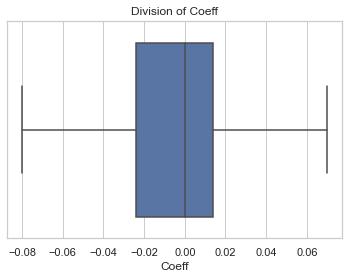

In [333]:
requirement_plot(df, 'Coeff', False)

As the boxplot of the coefficients shows, more than half of the observations are located between -0.05 and 0.05, which means that the effects of most statistics on the vote shares are again negligible. However, as vote shares are influenced by many factors, small coefficients could still indicate a relation between a certain statistic and the percentage of votes for a party. 

This concludes that the significance of the coefficients is not contributing heavily to the low scores of the regressions. The small coefficients could be a sign for the model not being able to explain much of the variation in the share of votes. The percentage of variation in the dependent variable explained by the independent variable is expressed in the $R^2$ value, which is visualised below:  

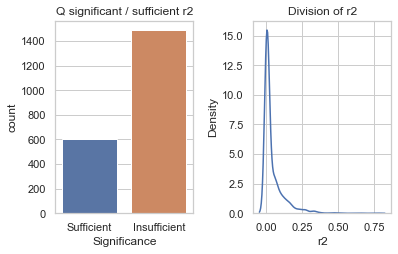

In [334]:
requirement_plot(df, 'r2')

The bar chart above shows that a clear majority of the regressions have an $R^2$ lower than 5\% which indicates that the model cannot explain much of the variation in the share of votes. The density estimation shows that there are values of $R^2$ that are relatively large and therefore indicates that in some of the models there is a clear explanation of the variation in the dependent variable. 

It has now been established how much the regressions can explain, but not whether these explanations can be trusted. For that, the 4 assumptions of linear models should not have been violated. These four values have been explained earlier in the analysis and therefore this paragraph will mainly focus on the outcomes of the values. The first of these assumptions mentioned was linearity, of which the resulting values are indicated in the column *Linearity*:

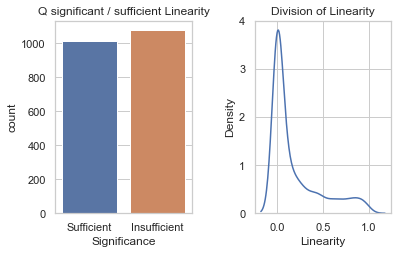

In [335]:
requirement_plot(df, 'Linearity', False)

The amount of regression marked as linear is almost equal to the amount of non-linear models, the group of non-linear regressions being slightly bigger. The density estimation shows that although the majority of the linearity values are centered around zero (and therefore are insufficient), there are still quite some values with values of 0.05 and larger, indicating that linearity is clearly present. As this essay is centered around simple linear regressions, estimates and results from models where the linearity assumption has been rejected cannot be trusted. 

The second assumption mentioned was independence of the error terms, expressed in the Durbin-Watson statistic. Even though data from several years has been used, the data points are taken from many municipalities and therefore I decided to exclude the Durbin-Watson test from the analysis. 

Normality was the third assumption and has been investigated using a Lilliefors test. The values of this test are in the data resulting from the `regress_all` function in a homonymous column. The results of these values are displayed below: 

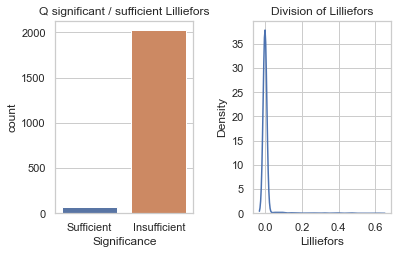

In [311]:
requirement_plot(df, 'Lilliefors')

The image above shows that normality is the main cause of the low regression scores: almost all the models do not have normally divided residuals. The density estimation shows that the majority of the values are centered around 0.0, which indicates that *H0: data is normally divided* can be rejected as it's smaller than the alpha value. According to Nieuwenhuis (2009), the results of a regression with non-normality are more trustworthy if the amount of observations is large. The results of parties that participated in many elections (VVD, CDA) can therefore be interpreted with less caution than newer parties such as DENK and Forum for Democracy. 

The last of the four assumptions is homoscedasticity, of which the values are included under the column *Homoscedasticity*. The results are visualised below: 

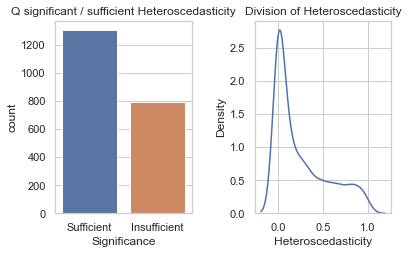

In [340]:
requirement_plot(df, 'Heteroscedasticity')

The two graphs show that the majority of the regressions is homoscedastic and therefore the homoscedasticity assumption improves the score of the models in general. The density estimation shows a peak around zero, which seems to indicate that the majority of the models score an insufficient in terms of the homoscedasticity as the H0 hypothesis (homoscedasticity) has been rejected. However, combining the bar chart and the density estimation, the peak should be interpreted as a centralisation of values. There are more values that do not reject homoscedasticity, but they are spread over a larger interval. 

In conclusion, there are only a few models that meet all the assumptions for the correct usage of simple linear regressions. The most models underperform on their capacity to explain the variation in the share of votes ($R^2$) or have residuals that are not normally divided. Therefore, it is not possible to interpret the results of most regressions without caution. However, in the next section, the best performing models are taken out in order to analyse the results, taking into consideration their weakness. 

## 7. Analysing the results of the regressions

To analyse the best performing regressions, their data firstly has to be separated from all the other values. The resulting table is displayed below: 

In [15]:
best  = df[df['Model_score'] == 5]
best
#len(best)

,Party,Statistic,Type,Coeff,pval_coeff,r2,Lilliefors,Linearity,Heteroscedasticity,Model_score
209,D66,KLFinancieleDienstenOnroerendGoed_169,votes_sqrt,0.6290,0.0,0.0514,0.1902,0.7578,0.075877,5
380,CDA,AantalZiekenhuizenBinnen20Km_213,votes_log,-0.0369,0.0,0.0693,0.0971,0.4568,0.186797,5
575,CDA,AantalBioscopenBinnen10Km_228,votes_log,-0.1057,0.0,0.1669,0.4720,0.0528,0.092022,5
623,VijftigPlus,AfstandTotOpenbaarGroen_231,votes_log,-0.3543,0.0,0.0618,0.2522,0.2368,0.487466,5
1286,VijftigPlus,AgrarischTerrein_265,votes_log,-0.0005,0.0,0.0710,0.0814,0.3911,0.623894,5
1759,SP,BijstandTotDeAOWLeeftijd_158,votes_sqrt,1.8776,0.0,0.0549,0.2213,0.0635,0.317551,5
2058,SP,BronOverdrachtsinkomen_149,votes_sqrt,-0.0004,0.0,0.1302,0.0657,0.6924,0.059168,5


The length of the table above shows that there are only a few combinations that satisfy all the assumptions for an accurate linear regression. What is striking as well is that the dependent variables all have been mutated: clearly the percentages from the database where not as accurate as a mutation of either the log or the square root from the vote percentages. The final list of correct models will become even shorter as both the distance to public green (AfstandTotOpenbaarGroen_321) compared to the VijftigPlus party and governmental transfer income (BronOverdrachtsinkomen_149) compared to the Socialist Party (SP) can be taken out because of a negligible coefficient. 

In [366]:
best = best[(best['Coeff'] > 0.01) | (best['Coeff'] < -0.01)]
best

,Party,Statistic,Type,Coeff,pval_coeff,r2,Lilliefors,Linearity,Heteroscedasticity,Model_score,Significance
209,D66,KLFinancieleDienstenOnroerendGoed_169,votes_sqrt,0.6290,0.0,0.0514,0.1902,0.7578,0.075877,5,Sufficient
380,CDA,AantalZiekenhuizenBinnen20Km_213,votes_log,-0.0369,0.0,0.0693,0.0971,0.4568,0.186797,5,Sufficient
575,CDA,AantalBioscopenBinnen10Km_228,votes_log,-0.1057,0.0,0.1669,0.4720,0.0528,0.092022,5,Sufficient
623,VijftigPlus,AfstandTotOpenbaarGroen_231,votes_log,-0.3543,0.0,0.0618,0.2522,0.2368,0.487466,5,Sufficient
1759,SP,BijstandTotDeAOWLeeftijd_158,votes_sqrt,1.8776,0.0,0.0549,0.2213,0.0635,0.317551,5,Sufficient


The linear regressions that have a meaningful coefficient and meet all the linear regression requirements are plotted separately using the function below. Because there are only five regressions to make, I decided to require the statistic, party and the type variable as they can easily be taken from the table above. 

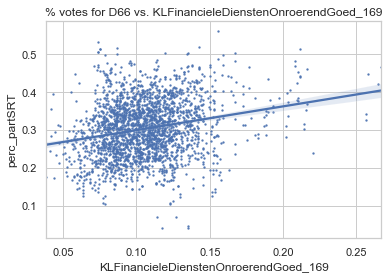

In [23]:
def plot_best(statistic, party, type):
    if type == 'votes_sqrt':
        type_val = 'perc_partSRT'
    elif type == 'votes_log':
        type_val = 'perc_partLOG'
    data = set_checkerdata(statistic, party)
    sns.regplot(x = statistic, y = type_val, data = data, scatter_kws={'s':2}).set_title(str('% votes for '+ party  + ' vs. ' + statistic))
    plt.show()
    plt.close()

plot_best('KLFinancieleDienstenOnroerendGoed_169', 'D66', 'votes_sqrt')


The figure above shows the linear regression of the squared percentage of votes the Democrats (D66) on the percentage of people that works in financial services and realty. The model suggests that the more people that work in financial services, the higher the squared percentage of people that vote for D66. The cloud of the scatterplot seems to be slightly upwards slowing, however there are many observations that are far away from the regression line. However, the regression line appears to be relatively accurate as the confidence band is narrow. 

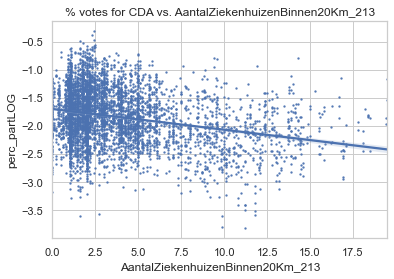

In [24]:
plot_best('AantalZiekenhuizenBinnen20Km_213', 'CDA','votes_log')

The regression of the natural logarithm of the percentage of votes for the Christian Democrats (CDA) on the number of hospitals within 20 kilometers is displayed above. With a slope of -0.0369 it indicates that if number of hospitals within 20 kilometers increases with one, the percentage of votes for the CDA decreases, on average, with $(e^{-0.0369}-1)\cdot 100\% = 3.62\%$. Note that the y-axis are negative numbers. This is caused by the logarithmic transformation: the result of *perc_partLOG* of -3.5 was normally 0.03 percent of the votes whereas a result of -0.5 indicates roughly 60 percent of the votes. The negative relationship of the amount of hospitals with the percentage of votes for the CDA is therefore still valid. This relationship could indicate that CDA voters live in relatively less accessible places, for example not in cities. However, to proof this further research is needed. 

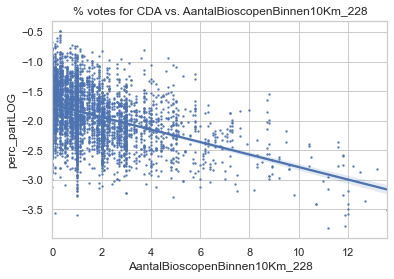

In [25]:
plot_best('AantalBioscopenBinnen10Km_228', 'CDA','votes_log')

The figure above displays the regression of the natural logarithm of the percentage of votes for the Christian Democrats on the number of cinemas within 10 kilometers. Although this is in essence a similar regression to the regression of CDA vote share on the number of hospitals, the coefficient in this regression is higher. The coefficient of -0.1057 indicates that if there would be one more cinema within 10 kilometers, the percentage of votes for the CDA decreases, on average, with 10.03%. Again, this could be an indication that CDA voters are not based in cities, but to proof this further research is required. 

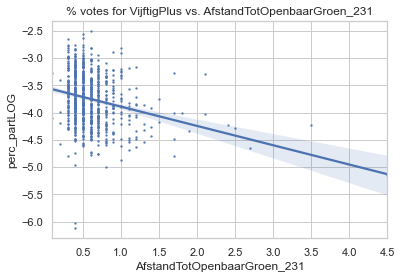

In [26]:
plot_best('AfstandTotOpenbaarGroen_231', 'VijftigPlus','votes_log')

This model regresses the natural logarithm of the percentage of votes for the Fifty Plus party on the distance to public green. The regression shows a negative relationship. Recalculating the coefficient in terms of percentages the regression states that if the distance to public parks increases with one kilometer, then the percentage of votes for the Fifty Plus party decreases, on average, with 29.83%. However, the model shows an increase in the width of the confidence band, especially for long distances to public green. Interpreting these results, it could suggest that older people or Fifty Plus party voters live in greener areas or closer to public parks. Again, this model alone is not sufficient to prove this hypothesis. 

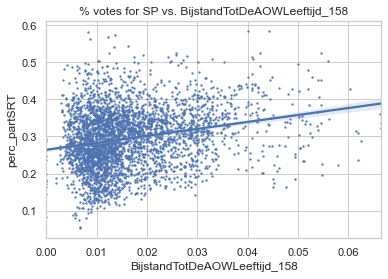

In [27]:
plot_best('BijstandTotDeAOWLeeftijd_158', 'SP','votes_sqrt')

This last regression shows the relationship between the square root of the vote share of the Socialist Party (SP) and the percentage of people that get social assistance benefit before reaching the retirement age necessary to get the governmental pension. The relationship between these two variables is clearly positive and indicates that if the percentage of people on welfare before retiring in a municipality increases by one, then the percentage of votes for the Socialist Party increases by 3.53%. This makes sense because people that need welfare benefits before retiring gain in general more from socialistic policies than from e.g. liberalistic policies. However, this regression is not enough for proving this. 

## 8. Conclusion

The main goal of this essay was to create a structured way of finding linear relationships between many variables and the percentages of votes for certain parties. From more than 2000 regressions, only adaptations of 5 of them satisfied the linear model assumptions. Especially the capacity of statistics to explain the variation in the percentage of votes was low, together with the linearity assumption. Next to that, practically all the models violated the normality assumption. As the number of correct linear regressions is less than a quarter of a percentage of all the possible combinations of statistics and parties, the conclusion can be drawn that in general, there is no linear relationship between the statistics of the CBS and the percentages of votes for parties. However, the coefficients in the exceptions that we found in the five regressions plotted earlier made sense considering the goal of the party and the accessory statistic. 

One of the issues in this essay might be that the data was only taken from municipalities as a whole. This means that the whole of e.g. Amsterdam is considered as one group. However, Amsterdam has many neighbourhoods with very different populations and statistics. If this research would be rewritten using the CBS data based on neighbourhoods, one could state that it would be easier to detect linear relationships.

Next to that, there might be other relationships between municipalities as a whole and the percentage of votes. As this paper only focussed on the automation of the process, merely linear relationships have been taken into consideration. Other models could extend this analysis and perhaps find more relationships between statistics and the vote shares of certain parties. However, this would increase the amount of possible outcomes,the complexity of the code and the time of running the analysis severely. Therefore, to find more relationships between statistics and the votes on parties, more resources are required to develop the code further, investigate regression methods and acquire detailed data of the Dutch Central Bureau of Statistics. 